Time Series prediction of tractor sales. 
Time series data have 4 major components:
1. Trend: Overall increase or decrease in pattern. 
2. Seasonality: Cyclic patterns through the series. 
3. Noise: Irregular and random changes in the series. 

To achieve good results of prediction, the time series data has to be decomposed of its respective components. It is much easier to forecast the individual regular patterns produced through decomposition of time series than the actual series.

# **Problem Definition**



In [2]:
import warnings
import itertools

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Visualising the data**

In [3]:
url = 'http://www.ucanalytics.com/blogs/wp-content/uploads/2015/06/Tractor-Sales.csv'

sales_data = pd.read_csv(url)


In [4]:
sales_data.head()## reading the data

,Month-Year,Number of Tractor Sold
0,Jan-03,141
1,Feb-03,157
2,Mar-03,185
3,Apr-03,199
4,May-03,203


In [5]:
sales_data.tail()

,Month-Year,Number of Tractor Sold
139,Aug-14,848
140,Sep-14,640
141,Oct-14,581
142,Nov-14,519
143,Dec-14,605


In [6]:
dates = pd.date_range(start='2003-01-01', freq='MS', periods=len(sales_data))

In [7]:
import calendar

In [8]:
sales_data['Month'] = dates.month
sales_data['Month'] = sales_data['Month'].apply(lambda x: calendar.month_abbr[x] )
sales_data['Year'] = dates.year

In [9]:
sales_data.rename(columns={'Number of Tractor Sold':'Tractor-Sales'}, inplace=True)
sales_data = sales_data[['Month', 'Year', 'Tractor-Sales']]

In [10]:
sales_data.set_index(dates, inplace=True)

In [11]:
sales_data

,Month,Year,Tractor-Sales
2003-01-01,Jan,2003,141
2003-02-01,Feb,2003,157
2003-03-01,Mar,2003,185
2003-04-01,Apr,2003,199
2003-05-01,May,2003,203
...,...,...,...
2014-08-01,Aug,2014,848
2014-09-01,Sep,2014,640
2014-10-01,Oct,2014,581
2014-11-01,Nov,2014,519


In [12]:
##extracting time series
sales_ts = sales_data['Tractor-Sales']

Text(0, 0.5, 'Tractor sold')

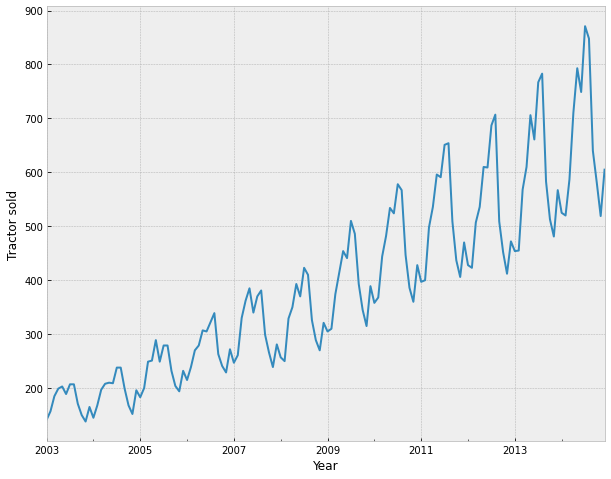

In [13]:
plt.figure(figsize=(10,8))
sales_ts.plot()
plt.xlabel('Year')
plt.ylabel('Tractor sold')

From the graph, it is evident that there is a trend in the tractor sales over the years. 
Yt=f(Trend t,Seasonality t,Remainder t)

Decomposing the series to understand trend, seasonality and noise.

Plotting rolling statistics of moving average and moving variance to iron out the wrinkles in the data and to see for a consant trend pattern. 


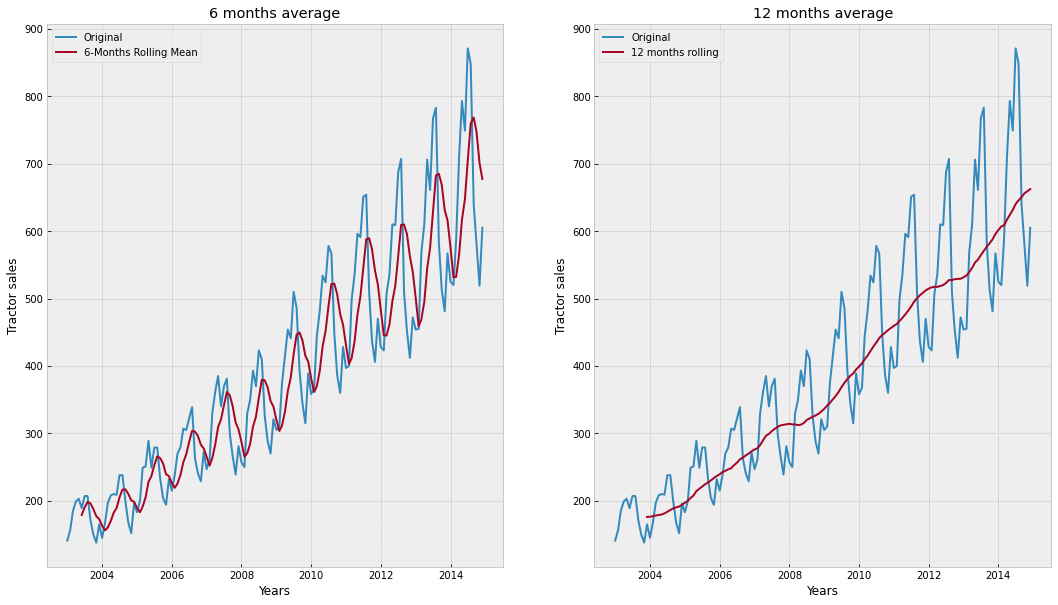

In [14]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False, squeeze=False)
fig.set_figwidth(18)
fig.set_figheight(10)
axes[0][0].plot(sales_ts.index, sales_ts, label='Original')
axes[0][0].plot(sales_ts.index, sales_ts.rolling(window=6).mean(), label='6-Months Rolling Mean')
axes[0][0].set_xlabel('Years')
axes[0][0].set_ylabel('Tractor sales')
axes[0][0].set_title('6 months average')
axes[0][0].legend()
axes[0][1].plot(sales_ts.index, sales_ts, label='Original')
axes[0][1].plot(sales_ts.index, sales_ts.rolling(window=12).mean(), label='12 months rolling')
axes[0][1].set_xlabel('Years')
axes[0][1].set_ylabel('Tractor sales')
axes[0][1].set_title('12 months average')
axes[0][1].legend()

As we could see in the above plots, 12-month moving average could produce a wrinkle free curve as desired. This on some level is expected since we are using month-wise data for our analysis and there is expected monthly-seasonal effect in our data.

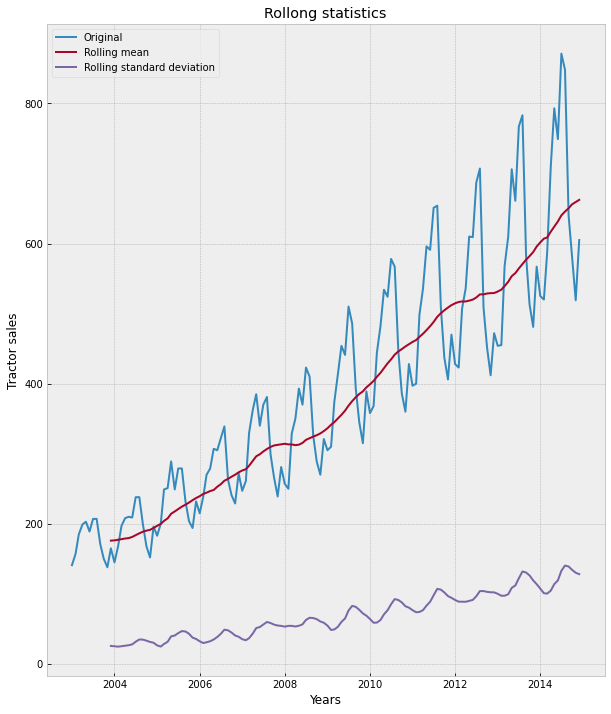

In [15]:
plt.figure(figsize=(10,12))
plt.plot(sales_ts.index, sales_ts, label='Original')
plt.plot(sales_ts.index, sales_ts.rolling(window=12).mean(), label='Rolling mean')
plt.plot(sales_ts.index, sales_ts.rolling(window=12).std(), label='Rolling standard deviation')
plt.xlabel('Years')
plt.ylabel('Tractor sales')
plt.title('Rollong statistics')
plt.legend()

Performing Dickey fuller test to check whether the series is not stationary or not. 
ADF (Augmented Dickey-Fuller) test is a statistical significance test which means the test will give results in hypothesis tests with null and alternative hypotheses. As a result, we will have a p-value from which we will need to make inferences about the time series, whether it is stationary or not.

In [16]:
from statsmodels.tsa.stattools import adfuller

In [17]:
dftest = adfuller(sales_ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
  dfoutput['Crtical value (%s)'%key]=value

dfoutput.to_frame()



,0
Test Statistic,1.108825
p-value,0.995291
#lags Used,14.000000
Number of Observations Used,129.000000
Crtical value (1%),-3.482088
Crtical value (5%),-2.884219
Crtical value (10%),-2.578864


**Time Series- Seasonality**

Seperating seasonal component and plotting it. 

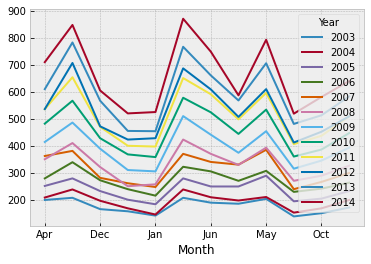

In [18]:
monthly_sales_data = pd.pivot_table(sales_data, values='Tractor-Sales',columns='Year', index='Month')
monthly_sales_data.plot()

There is a clear pattern of seasonality in the above data. 

The tractor sales have been increasing every year. 

There is a seasonality repeating once in 12 months. 

**Time series- Decomposition**

In [19]:
decomposition = sm.tsa.seasonal_decompose(sales_ts, model='multiplicative')

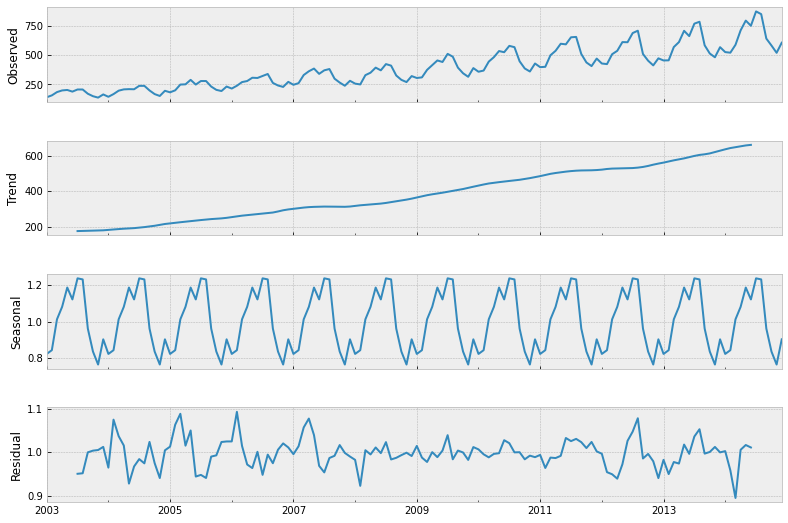

In [20]:
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)

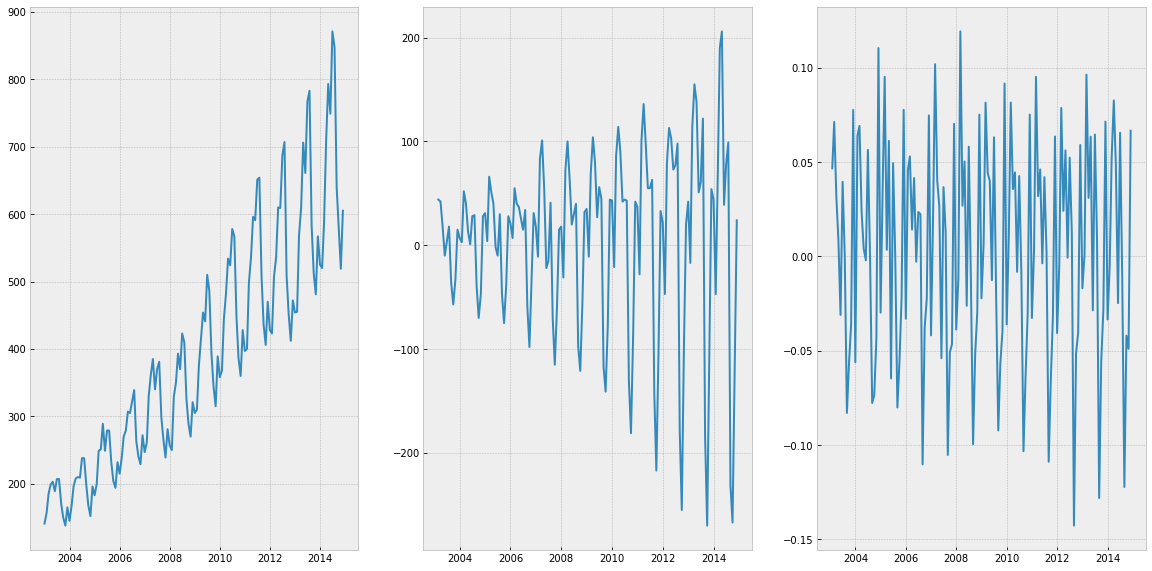

In [21]:
fig, axes = plt.subplots(1,3, squeeze=False)
fig.set_figwidth(20)
fig.set_figheight(10)
axes[0][0].plot(sales_ts.index, sales_ts)
axes[0][1].plot(sales_ts.index, sales_ts.diff(periods=2))
axes[0][2].plot(sales_ts.index, (np.log10(sales_ts).diff(periods=1)))

In [22]:
sales_ts_log = np.log10(sales_ts)
sales_ts_diff = sales_ts_log.diff(periods=1)
sales_ts_diff.dropna(inplace=True)

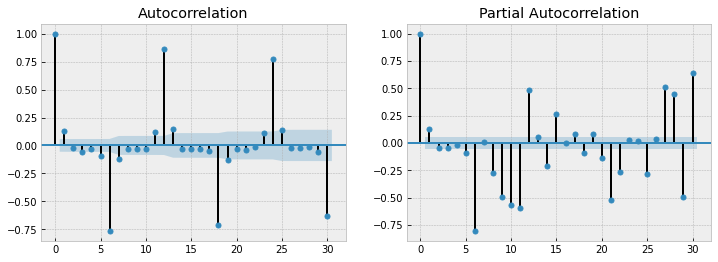

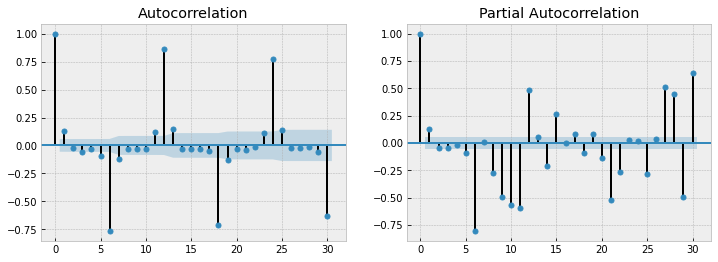

In [23]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(sales_ts_diff, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(sales_ts_diff, lags=30, ax=axes[1], alpha=0.5)

In [24]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [25]:
import sys
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(0, 1, 1)x(1, 0, 1, 12)12 model - AIC:-733.7743756637756


Predicting sales

In [26]:
best_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                      order=(0, 1, 1),
                                      seasonal_order=(1, 0, 1, 12),
                                      enforce_stationarity=True,
                                      enforce_invertibility=True)
best_results = best_model.fit()

In [27]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                      Tractor-Sales   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 370.887
Date:                            Wed, 22 Jun 2022   AIC                           -733.774
Time:                                    06:53:10   BIC                           -721.923
Sample:                                01-01-2003   HQIC                          -728.959
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3581      0.069     -5.207      0.000      -0.493      -0.223
ar.S.L12       0.9933      0.006   

In [28]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [29]:
# Extract the predicted and true values of our time series
sales_ts_forecasted = pred_dynamic.predicted_mean
sales_ts_truth = sales_ts_log['2012-01-01':]

# Compute the mean square error
mse = ((sales_ts_forecasted - sales_ts_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))

The Mean Squared Error of our forecasts is 0.0011


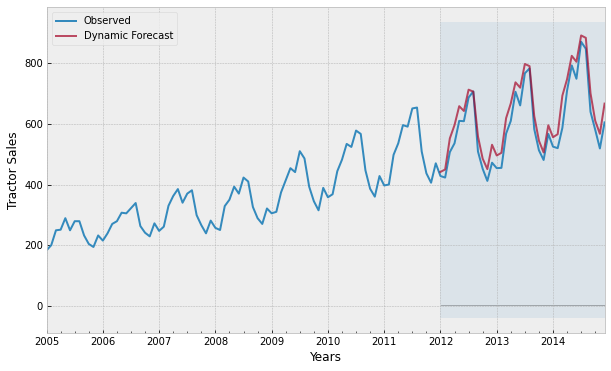

In [30]:
axis = sales_ts['2005':].plot(label='Observed', figsize=(10, 6))
np.power(10, pred_dynamic.predicted_mean).plot(ax=axis, label='Dynamic Forecast', alpha=0.7)
axis.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
axis.fill_betweenx(axis.get_ylim(), pd.to_datetime('2012-01-01'), sales_ts.index[-1], alpha=.1, zorder=-1)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()
plt.close()

Forecasting sales

In [31]:
# Get forecast 36 steps (3 years) ahead in future
n_steps = 36
pred_uc_99 = best_results.get_forecast(steps=36, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=36, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [32]:
n_steps = 36
idx = pd.date_range(sales_ts.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10, pred_ci_99)]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2014-12-01,567.472702,528.231908,609.628579,528.231908,609.628579
2015-01-01,566.198201,519.982050,616.522057,519.982050,616.522057
2015-02-01,668.777599,607.087035,736.736993,607.087035,736.736993
2015-03-01,755.227074,678.486360,840.647604,678.486360,840.647604
2015-04-01,850.257036,756.671592,955.417166,756.671592,955.417166


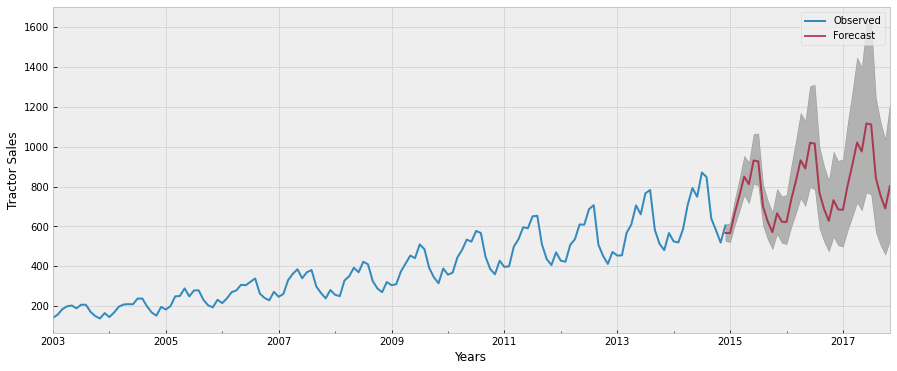

In [33]:
# plot the forecast along with the confidence band
axis = sales_ts.plot(label='Observed', figsize=(15, 6))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.25)
#axis.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color='k', alpha=.75)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()

Now, forecasts for a long period of 3 years is an ambitious task. The major assumption here is that the underlining patterns in the time series will continue to stay the same as predicted in the model. A short-term forecasting model, say a couple of business quarters or a year, is usually a good idea to forecast with reasonable accuracy. A long-term model like the one above needs to evaluated on a regular interval of time (say 6 months). The idea is to incorporate the new information available with the passage of time in the model.